# Probability Models for NLP

## Anoop Sarkar

This is a brief, interactive guide to probability theory. It provides an  introduction to the basic concepts we will rely on to build models of uncertainty in natural language processing.

In [56]:
%matplotlib inline
from __future__ import division
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pylab
import nltk
import random
import json
from operator import itemgetter
from collections import defaultdict

## NLTK as a data source

We will use the [Python Natural Language Toolkit](http://nltk.org) as a source of data. 
First step, let us load up some text data from Lewis Carroll's "Alice's Adventures in Wonderland" and print out the first few words from the book. 
Notice that NLTK has already split up all the text in that book into tokens we can use.

In [57]:
from itertools import islice
# print the first few words from Lewis Carroll's "Alice's Adventures in Wonderland"
# islice takes the first n elements from the iterator without building the whole list of words for the document
print [w for w in islice(nltk.corpus.gutenberg.words('carroll-alice.txt'),85)]

[u'[', u'Alice', u"'", u's', u'Adventures', u'in', u'Wonderland', u'by', u'Lewis', u'Carroll', u'1865', u']', u'CHAPTER', u'I', u'.', u'Down', u'the', u'Rabbit', u'-', u'Hole', u'Alice', u'was', u'beginning', u'to', u'get', u'very', u'tired', u'of', u'sitting', u'by', u'her', u'sister', u'on', u'the', u'bank', u',', u'and', u'of', u'having', u'nothing', u'to', u'do', u':', u'once', u'or', u'twice', u'she', u'had', u'peeped', u'into', u'the', u'book', u'her', u'sister', u'was', u'reading', u',', u'but', u'it', u'had', u'no', u'pictures', u'or', u'conversations', u'in', u'it', u',', u"'", u'and', u'what', u'is', u'the', u'use', u'of', u'a', u'book', u",'", u'thought', u'Alice', u"'", u'without', u'pictures', u'or', u'conversation', u"?'"]


## Probability Distributions

### Sampling without replacement

For now, let us view the text as a bag of letters taken from the English alphabet. By a "bag" of letters, we mean that we take this book to consist of unordered letter tokens, and so the ordering or the sequence in which the letters occur is ignored for now.

To create a new sample, we simply choose a letter at random and add it to our sample. We do not remove the letter from our list because we are *sampling with replacement*, and repeatedly sample again and again until we reach a sample of a desired size.

The class `lettersample` below produces a sample of a desired size `num`. If a letter appears more often in the original list of letters from which we are sampling, then that letter will appear proportionally more often in our sample.

In [58]:
# sample letters from a document with replacement
class lettersample:
    
    def __init__(self, num):
        self.corpus = [c.lower() for sent in nltk.corpus.gutenberg.sents('carroll-alice.txt') for c in ''.join(sent)]
        self.sample = [random.choice(self.corpus) for i in range(num)]

    # __str__ creates a printable representation of the object
    def __str__(self):
        return ''.join(self.sample)

In [59]:
s = lettersample(6)
print ''.join(s.sample) # print the sample

odshel


### Creating a probability distribution from a sample

When we have a sample, we can count how many times each letter $c$ occured in the sample. Let us call this the frequency of $c$ or $n(c)$.

For example, if we have a random sample of size 6: $eeaaei$ then $n(e) = 3$, $n(a) = 2$, $n(i) = 1$. Notice that $\sum_{c} n(c) = n(e) + n(a) + n(i) = 6$ which is the sample size.

In [60]:
s = lettersample(6)
n = defaultdict(int)
for c in s.sample:
    n[c] += 1
print json.dumps(n, indent=4)
print "sample size:", sum(n.values())

{
    "c": 1, 
    "e": 1, 
    "h": 1, 
    "o": 1, 
    "n": 1, 
    "y": 1
}
sample size: 6




We can create probability distribution over the set of letters (the alphabet) by simply summing over the number of times we observed a letter in the sample and dividing by the number of times we observed all the letters (which is the same as the size of the sample). If $n(c)$ is the count of letter $c$ then we can write down the probability of any letter $c$ as 

$$ P(c) = \frac{n(c)}{\sum_{c'} n(c')} $$

As we just observed in the above example, $\sum_{c'} n(c')$ is equal to the sample size.

$P(c)$ is called the unigram letter probability.

In [61]:
total = sum(n.values())
prob = { c: (n[c] / total) for c in n.keys() }
print json.dumps(prob, indent=4)

{
    "c": 0.16666666666666666, 
    "e": 0.16666666666666666, 
    "h": 0.16666666666666666, 
    "o": 0.16666666666666666, 
    "n": 0.16666666666666666, 
    "y": 0.16666666666666666
}


### Probability distribution

A probability is a real number between zero and one. A probability distribution is created over a set where each element in the set has a probability and the sum over all elements in this set must sum to one. So if our set was called $S$ then this condition on the probability distribution $P$ over elements of set $S$ is written as 

$$ \sum_{c \in S} P(c) = 1.0 $$


In [62]:
print sum(prob.values())

1.0


* $S$ is the _sample space_
* A random variable $X$ is a function from $S$ to disjoint subset of $S$

For example:

$S = \{ a, b, c, \ldots z \}$

$X(c) = c$ where $c \in S$

### Finding the argmax

Often we wish to compute the argmax using a probability distribution. The argmax function returns the element that has the highest probability. $$\hat{c} = \arg\max_c P(c)$$

In [63]:
def P(c):
    return prob[c]
# the character with the highest probability is given by argmax_c P(c)
argmax_char = max(n.keys(), key=P)
print argmax_char, P(argmax_char)

c 0.166666666667


### Sample size and probability estimates

We can observe that larger samples result in a more accurate measurement of the probability.

In [64]:
def sample_dist(fdist):
    return([ (sample, fdist[sample]) for sample in fdist ])

def vertical_bars(sample_dist):
    samples = map(itemgetter(0), sample_dist)
    freqs = map(itemgetter(1), sample_dist)
    # samples = fdist.samples()
    # freqs = [ fdist[sample] for sample in samples ]
    labels = [str(s) for s in samples]
    fig, ax1 = plt.subplots(figsize=(15, 10))
    pos = numpy.arange(len(labels))
    ax1.bar(pos, freqs, facecolor='#9999ff', edgecolor='white')
    font = matplotlib.font_manager.FontProperties()
    font.set_size('x-large')
    for x,y in zip(pos,freqs):
        ax1.text(x+0.4, y+0.05, '%s' % labels[x], fontproperties=font, ha='center', va= 'bottom')
    plt.tick_params(\
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
    plt.show()

Let us plot the probability distribution over letters when the sample size is 100.

In [65]:
sample1 = lettersample(100)
print ''.join(sample1.sample[:100]) # print the first 100 chars

:emkosnwhrtohsaqe.tl'h,nnaoey"hrrac,uuwntafsrr'odmiotrenteudpactetr,tesitsbedyoyongp.ooeioc,orhvhn,i


[(u'"', 1), (u"'", 2), (u',', 5), (u'.', 2), (u':', 1), (u'a', 5), (u'c', 3), (u'b', 1), (u'e', 9), (u'd', 3), (u'g', 1), (u'f', 1), (u'i', 4), (u'h', 6), (u'k', 1), (u'm', 2), (u'l', 1), (u'o', 11), (u'n', 7), (u'q', 1), (u'p', 2), (u's', 5), (u'r', 8), (u'u', 3), (u't', 9), (u'w', 2), (u'v', 1), (u'y', 3)]


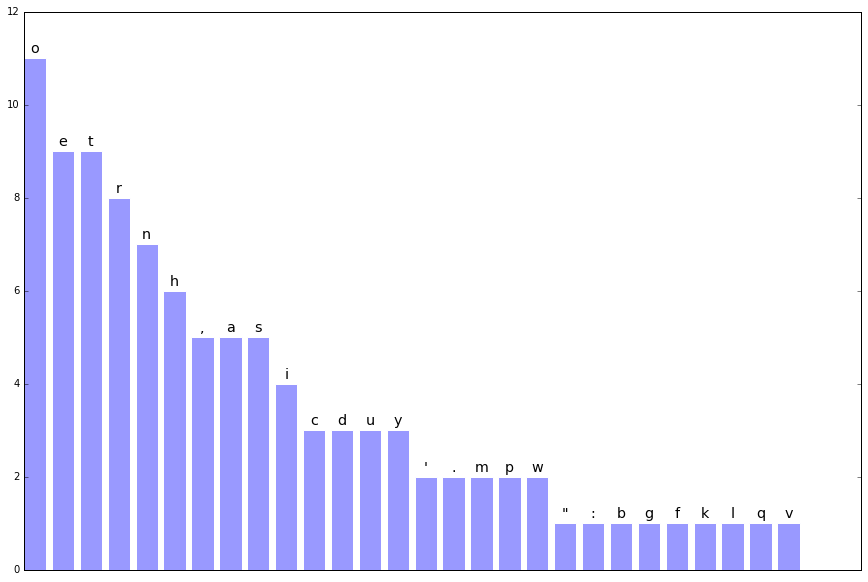

In [73]:
fdist1 = nltk.probability.FreqDist(sample1.sample)
print sample_dist(fdist1)
vertical_bars(sorted(sample_dist(fdist1), reverse=True, key=itemgetter(1)))

Now let us take a larger sample of 100,000 characters. The plot of the probability distribution now shows a more accurate likelihood of each character in English.

In [52]:
sample2 = lettersample(100000)
print ''.join(sample2.sample[:100]) # print the first 100 chars

h,ua'eanwaaeoahneoewetsnfiu;aatrfrghc.shothankhe'edotdpcthtyeaaopeoaoinhhnoeuhoj'ieodtsdcecbhlleho,w


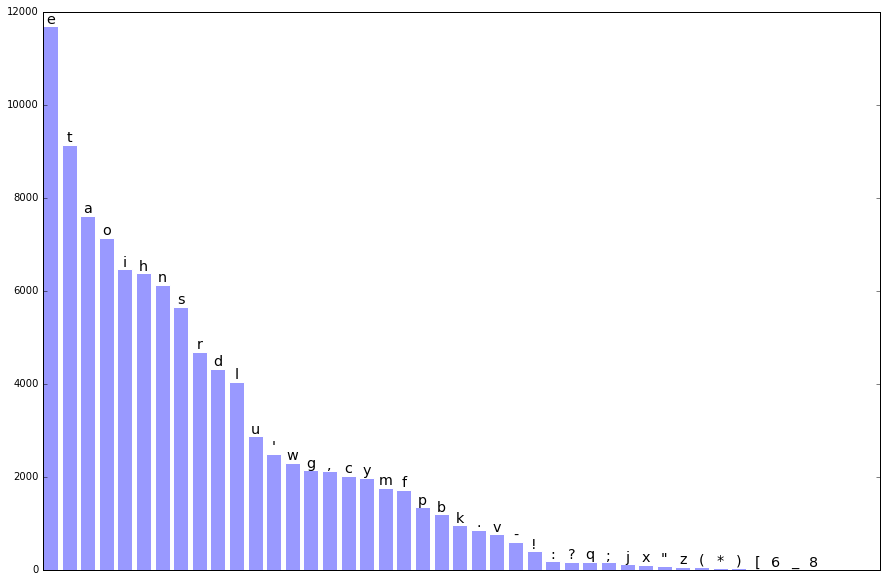

In [74]:
fdist2 = nltk.probability.FreqDist(sample2.sample)
vertical_bars(sorted(sample_dist(fdist2), reverse=True, key=itemgetter(1)))

### Random Probability Distributions

Now let us compare a character sample taken from a real English document with a totally random assignment of probabilities to English characters. The difference in the distribution is not just in the assignment of probabilities to individual characters, but the shape of the distribution is altogether different.

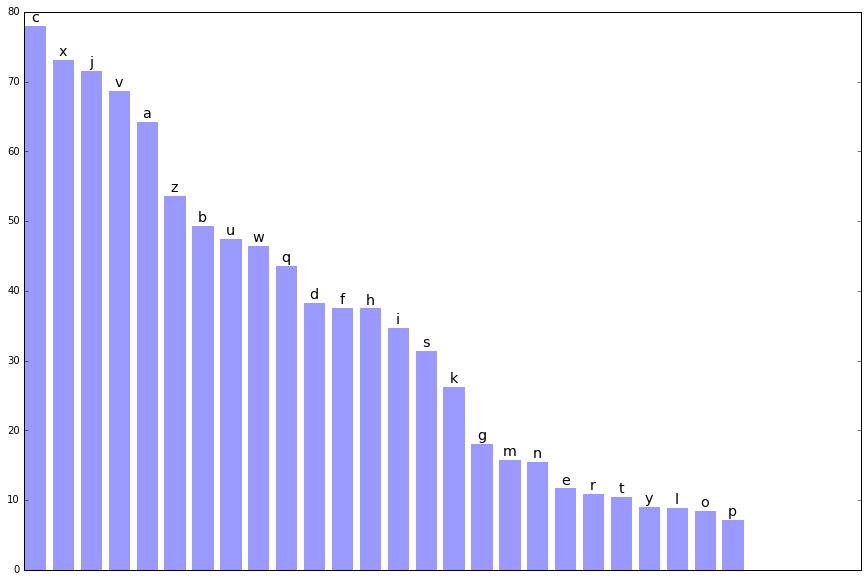

In [76]:
import string
import numpy
# set up a random probability distribution over lowercase ASCII characters
counts = [ 100*numpy.random.random() for c in string.ascii_lowercase ]
sample_dist = [ (c, counts[i]) for (i,c) in enumerate(string.ascii_lowercase) ]
vertical_bars(sorted(sample_dist, reverse=True, key=itemgetter(1)))

In [39]:
total = sum(counts)
# the following is a dictionary comprehension
prob = { c: (counts[i] / total) for (i,c) in enumerate(string.ascii_lowercase) }
print prob['e']
print prob['z']

0.0159117848097
0.0683250034794


### Joint Probability Distributions

In [40]:
# sample letter bigrams from a document with replacement
class bigramsample:
    
    def __init__(self, num):
        self.corpus = [c.lower() for sent in nltk.corpus.gutenberg.sents('carroll-alice.txt') for c in ''.join(sent)]
        self.bigrams = [ tuple(self.corpus[i:i+2]) for i in range(len(self.corpus)-1) ]
        self.sample = [random.choice(self.bigrams) for i in range(num)]

    # __str__ creates a printable representation of the object
    def __str__(self):
        return ''.join(self.sample)

In [41]:
b = bigramsample(100)
print '\n'.join(["%c,%c" % (x,y) for (x,y) in b.sample[:10] ]) # print the first 10 bigrams sampled

s,s
e,p
l,e
e,s
u,s
f,a
a,r
i,v
l,k
d,b


In [42]:
s = bigramsample(100)
n = defaultdict(int)
for (x,y) in s.sample:
    n[x,y] += 1
for (x,y) in n.keys()[:10]: # print 10 items from the sample
    print "%c %c: %d" % (x, y, n[x,y])
print "sample size:", sum(n.values())

d e: 2
t t: 2
t !: 1
b l: 1
e d: 3
o f: 1
h i: 1
r e: 1
e o: 1
c k: 1
sample size: 100


Sample space $S = \{ a, b, c, \ldots, z \}^2$

Random variable $X(x,y) = x$ and $Y(x,y) = y$

In [43]:
total = sum(n.values())
prob = { (x,y): (n[x,y] / total) for (x,y) in n.keys() }
for (x,y) in prob.keys()[:10]: # print 10 probabilities
    print "%c %c: %f" % (x, y, prob[x,y])

o c: 0.010000
d e: 0.020000
t t: 0.020000
t !: 0.010000
b l: 0.010000
e d: 0.030000
" u: 0.010000
h i: 0.010000
r e: 0.010000
e o: 0.010000


### Finding the argmax of a joint probability

The argmax of a joint probability distribution is the values for the joint random variables that returns the highest _joint_ probability. 
$$\hat{x},\hat{y} = \arg\max_{x,y} P(X=x,Y=y)$$
Which can be written as:
$$\hat{x},\hat{y} = \arg\max_{x,y} P(x,y)$$

In [44]:
def P(key):
    (x,y) = key
    return prob[x,y]
# the character with the highest probability is given by argmax_{x,y} P(x,y)
(argmax_x, argmax_y) = max(n.keys(), key=P)
print "%c %c: %f" % (argmax_x, argmax_y, P((argmax_x,argmax_y)))

e d: 0.030000


### Marginal Probability

A probability distribution over a subset of variables is a _marginal probability_. We can find the probability value of a particular second character by summing over or _marginalizing out_ the first character probabilities.
$$ P(Y=d) = \sum_{x \in X} P(X=x, Y=d) $$

In [45]:
marginal = { (x,y) : prob[x,y] for (x,y) in prob.keys() if y == argmax_y }
print marginal
print "P(Y=%c)=%f" % (argmax_y, sum(marginal.values()))

{(u'e', u'd'): 0.03, (u'n', u'd'): 0.01}
P(Y=d)=0.040000


### The End

In [46]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../css/notebook.css", "r").read()
    return HTML(styles)
css_styling()

In [47]:
def horizontal_bars(fdist):
    samples = fdist.samples()
    freqs = [ fdist[sample] for sample in samples ]
    labels = ["'" + str(s) + "'" for s in samples]
    fig, ax1 = plt.subplots(figsize=(15, 10))
    plt.subplots_adjust(left=0.115, right=0.88)
    pos = numpy.arange(len(labels))+0.5    # Center bars on the Y-axis ticks
    rects = ax1.barh(pos, freqs, align='center', height=0.5, color='m')
    ax1.axis([0, fdist[fdist.max()], 0, len(labels)])
    pylab.yticks(pos, labels)
    plt.show()